## *ESSENTIAL LIBRARY IMPORTS*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from tqdm import tqdm
import xml.etree.ElementTree as ET
import time

import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image,ImageOps,ImageEnhance

In [2]:
TIME_LIMIT = 18000 - 60*10
start_time = time.time()
def elapsed_time(start_time):
    return time.time() - start_time

## *FETCHING THE DATASET*

The dataset consists of a large collection of images, with each image corresponding to a specific dog breed. It covers a wide range of dog breeds, including popular ones like Labrador Retriever, German Shepherd, Chihuahua, and many others. The dataset provides a diverse set of images capturing various angles, poses, and appearances of different dog breeds.

Each image in the dataset is accompanied by annotations, which include the bounding box coordinates and the corresponding breed label. These annotations are valuable for tasks such as object detection and localization. The dataset also includes a hierarchical taxonomy of dog breeds, which provides a hierarchical structure for the breeds based on their lineage.

The Stanford Dogs dataset has been widely used for training and evaluating deep learning models in the field of computer vision. Researchers and practitioners leverage this dataset to develop algorithms that can recognize and classify dog breeds accurately. It has also been used as a benchmark dataset for evaluating the performance of different image recognition models.

In [3]:
# Setting the Paths to the dataset Folders

image_path = 'C:/Users/nitya/OneDrive/Documents/GitHub Docs/EE240/Project/Datasets/all-dogs/all-dogs'
annotations_path = 'C:/Users/nitya/OneDrive/Documents/GitHub Docs/EE240/Project/Datasets/Annotation/Annotation'

## *PREPROCESSING*

In [4]:
# Specifying Parameters
BATCH_SIZE = 32
EMA = False
LABEL_NOISE = False
LABEL_NOISE_PROB = 0.1

In [5]:
images_path = image_path

img_filenames = []
for dirpath, dirnames, filenames in os.walk(images_path):
    img_filenames.extend(filenames)

print(f'Total number of images in the Dataset = {len(img_filenames)}')

Total number of images in the Dataset = 20579


In [6]:
annotations = []

# os.walk() generates the file names in a directory tree
for subdir, dirs, files in os.walk(annotations_path):
    for file in files:
        annotations.append(file)

# prints the list of all file names
print(f'Total Number of files containing annotations for the Images = {len(annotations)-1}')

Total Number of files containing annotations for the Images = 20579


In [7]:
breeds = glob.glob(annotations_path + '*')
annotations = []

for breed in breeds:
    annotations += glob.glob(breed + '/*')

print(f'Total No of Subdirectories in the Annotations dir = {len(annotations)}')

Total No of Subdirectories in the Annotations dir = 120


In [8]:
breed_map = {}

for annotation in annotations:
    breed = annotation.split('/')[-1]
    parts = breed.split('-')
    index = parts[0].split('\\')[-1]  # Extract the last part of the index after splitting by '\\'
    breed_name = '-'.join(parts[1:])
    breed_map.setdefault(index, index + '-' + breed_name)
    
n_classes = len(breed_map)
print(f'Total Number of Classes in the Dataset = {n_classes}')

Total Number of Classes in the Dataset = 120


In [9]:
breed_map

{'n02085620': 'n02085620-Chihuahua',
 'n02085782': 'n02085782-Japanese_spaniel',
 'n02085936': 'n02085936-Maltese_dog',
 'n02086079': 'n02086079-Pekinese',
 'n02086240': 'n02086240-Shih-Tzu',
 'n02086646': 'n02086646-Blenheim_spaniel',
 'n02086910': 'n02086910-papillon',
 'n02087046': 'n02087046-toy_terrier',
 'n02087394': 'n02087394-Rhodesian_ridgeback',
 'n02088094': 'n02088094-Afghan_hound',
 'n02088238': 'n02088238-basset',
 'n02088364': 'n02088364-beagle',
 'n02088466': 'n02088466-bloodhound',
 'n02088632': 'n02088632-bluetick',
 'n02089078': 'n02089078-black-and-tan_coonhound',
 'n02089867': 'n02089867-Walker_hound',
 'n02089973': 'n02089973-English_foxhound',
 'n02090379': 'n02090379-redbone',
 'n02090622': 'n02090622-borzoi',
 'n02090721': 'n02090721-Irish_wolfhound',
 'n02091032': 'n02091032-Italian_greyhound',
 'n02091134': 'n02091134-whippet',
 'n02091244': 'n02091244-Ibizan_hound',
 'n02091467': 'n02091467-Norwegian_elkhound',
 'n02091635': 'n02091635-otterhound',
 'n020918

In [10]:
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def bounding_box(img):
    """
    Reads bounding box coordinates from an XML file and returns a list of tuples representing the bounding boxes.

    Args:
        img (str): The image filename or identifier.

    Returns:
        list: A list of tuples representing the bounding box coordinates in the format (xmin, ymin, xmax, ymax).
    """
    # Construct the path to the XML file using annotations_path, breed_map, and the image identifier
    bpath = annotations_path + '/' + str(breed_map[img.split('_')[0]]) + '/' + str(img.split('.')[0])

    # Parse the XML file
    tree = ET.parse(bpath)
    root = tree.getroot()
    
    # Find all 'object' elements in the XML
    objects = root.findall('object')
    
    # Initialize an empty list to store the bounding box coordinates
    bbxs = []
    
    # Iterate over each 'object' element
    for o in objects:
        # Find the 'bndbox' element within the 'object'
        bndbox = o.find('bndbox')
        
        # Read and convert the coordinates to integers
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        # Append the bounding box coordinates as a tuple to the bbxs list
        bbxs.append((xmin, ymin, xmax, ymax))
    
    # Return the list of bounding box coordinates
    return bbxs

In [11]:
def bounding_box_ratio(img):
    """
    Reads bounding box coordinates from an XML file and calculates the width, height, and ratio for each bounding box.
    Returns a list of tuples representing the bounding box information.

    Args:
        img (str): The image filename or identifier.

    Returns:
        list: A list of tuples representing the bounding box information in the format (width, height, ratio).
    """
    # Construct the path to the XML file using annotations_path, breed_map, and the image identifier
    bpath = annotations_path + '/' + str(breed_map[img.split('_')[0]]) + '/' + str(img.split('.')[0])

    # Parse the XML file
    tree = ET.parse(bpath)
    root = tree.getroot()

    # Find all 'object' elements in the XML
    objects = root.findall('object')

    # Initialize an empty list to store the bounding box information
    bbx_ratios = []

    # Iterate over each 'object' element
    for o in objects:
        # Find the 'bndbox' element within the 'object'
        bndbox = o.find('bndbox')

        # Read and convert the coordinates to integers
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Calculate the width and height of the bounding box
        xlen = xmax - xmin
        ylen = ymax - ymin

        # Calculate the ratio of height to width
        ratio = ylen / xlen

        # Append the bounding box information as a tuple to the bbx_ratios list
        bbx_ratios.append((xlen, ylen, ratio))

    # Return the list of bounding box information
    return bbx_ratios

In [12]:
img_filenames_th = []  # Initialize an empty list to store image filenames that pass the ratio threshold
ratios_th = []  # Initialize an empty list to store the ratios of bounding boxes that pass the threshold

# Iterate over each image filename in the img_filenames list
for img in tqdm(img_filenames):
    # Get the bounding box ratios for the current image
    bbx_ratios = bounding_box_ratio(img)
    
    # Iterate over each bounding box ratio in the bbx_ratios list
    for i, (xlen, ylen, ratio) in enumerate(bbx_ratios):
        # Check if the ratio is within the desired range (0.2 to 4.0)
        if (ratio > 0.2) and (ratio < 4.0):
            # Append the modified image filename and the ratio to the respective lists
            img_filenames_th.append(img[:-4] + '_' + str(i) + '.jpg')
            ratios_th.append(ratio)

# Convert the ratios list to a numpy array for further processing
ratios_th = np.array(ratios_th)

print()

# Print the original number of image filenames and the number after applying the threshold
print()
print(f'Original number of filenames = {len(img_filenames)}')
print(f'Number of filenames after applying threshold = {len(img_filenames_th)}')

100%|██████████| 20579/20579 [00:01<00:00, 14124.23it/s]



Original number of filenames = 20579
Number of filenames after applying threshold = 22119


In [13]:
#from https://www.kaggle.com/korovai/dogs-images-intruders-extraction
intruders = [
    #n02088238-basset
    'n02088238_10870_0.jpg',
    
    #n02088466-bloodhound
    'n02088466_6901_1.jpg',
    'n02088466_6963_0.jpg',
    'n02088466_9167_0.jpg',
    'n02088466_9167_1.jpg',
    'n02088466_9167_2.jpg',
    
    #n02089867-Walker_hound
    'n02089867_2221_0.jpg',
    'n02089867_2227_1.jpg',
    
    #n02089973-English_foxhound # No details
    'n02089973_1132_3.jpg',
    'n02089973_1352_3.jpg',
    'n02089973_1458_1.jpg',
    'n02089973_1799_2.jpg',
    'n02089973_2791_3.jpg',
    'n02089973_4055_0.jpg',
    'n02089973_4185_1.jpg',
    'n02089973_4185_2.jpg',
    
    #n02090379-redbone
    'n02090379_4673_1.jpg',
    'n02090379_4875_1.jpg',
    
    #n02090622-borzoi # Confusing
    'n02090622_7705_1.jpg',
    'n02090622_9358_1.jpg',
    'n02090622_9883_1.jpg',
    
    #n02090721-Irish_wolfhound # very small
    'n02090721_209_1.jpg',
    'n02090721_1222_1.jpg',
    'n02090721_1534_1.jpg',
    'n02090721_1835_1.jpg',
    'n02090721_3999_1.jpg',
    'n02090721_4089_1.jpg',
    'n02090721_4276_2.jpg',
    
    #n02091032-Italian_greyhound
    'n02091032_722_1.jpg',
    'n02091032_745_1.jpg',
    'n02091032_1773_0.jpg',
    'n02091032_9592_0.jpg',
    
    #n02091134-whippet
    'n02091134_2349_1.jpg',
    'n02091134_14246_2.jpg',
    
    #n02091244-Ibizan_hound
    'n02091244_583_1.jpg',
    'n02091244_2407_0.jpg',
    'n02091244_3438_1.jpg',
    'n02091244_5639_1.jpg',
    'n02091244_5639_2.jpg',
    
    #n02091467-Norwegian_elkhound
    'n02091467_473_0.jpg',
    'n02091467_4386_1.jpg',
    'n02091467_4427_1.jpg',
    'n02091467_4558_1.jpg',
    'n02091467_4560_1.jpg',
    
    #n02091635-otterhound
    'n02091635_1192_1.jpg',
    'n02091635_4422_0.jpg',
    
    #n02091831-Saluki
    'n02091831_1594_1.jpg',
    'n02091831_2880_0.jpg',
    'n02091831_7237_1.jpg',
    
    #n02092002-Scottish_deerhound
    'n02092002_1551_1.jpg',
    'n02092002_1937_1.jpg',
    'n02092002_4218_0.jpg',
    'n02092002_4596_0.jpg',
    'n02092002_5246_1.jpg',
    'n02092002_6518_0.jpg',
    
    #02093256-Staffordshire_bullterrier
    'n02093256_1826_1.jpg',
    'n02093256_4997_0.jpg',
    'n02093256_14914_0.jpg',
    
    #n02093428-American_Staffordshire_terrier
    'n02093428_5662_0.jpg',
    'n02093428_6949_1.jpg'
            ]

len(intruders)

60

In [14]:
def data_preprocessing(img_path, bbx_idx):
    """
    Preprocesses an image by cropping it based on the specified bounding box index.

    Args:
        img_path (str): The path to the image file.
        bbx_idx (int): The index of the bounding box to crop.

    Returns:
        img_cropped (PIL.Image.Image): The cropped image.
    """

    # Get the bounding box coordinates for the specified index
    bbx = bounding_box(img_path)[bbx_idx]

    # Open the image using PIL
    img = Image.open(os.path.join(image_path, img_path))

    # Crop the image based on the bounding box coordinates
    img_cropped = img.crop(bbx)

    # Return the cropped image
    return img_cropped

In [15]:
%%time

breed_map_2 = {}
for i,b in enumerate(tqdm(breed_map.keys())):
    breed_map_2[b] = i

100%|██████████| 120/120 [00:00<?, ?it/s]

Wall time: 2 ms


In [16]:
class DogDataset(Dataset):
    """
    Custom dataset class for handling dog images and labels.

    Args:
        path (str): The path to the dataset.
        img_list (list): The list of image filenames.
        transform1 (callable, optional): The first transformation to apply to the images.
        transform2 (callable, optional): The second transformation to apply to the images.

    Attributes:
        path (str): The path to the dataset.
        img_list (list): The list of image filenames.
        transform1 (callable): The first transformation to apply to the images.
        transform2 (callable): The second transformation to apply to the images.
        imgs (list): The list of preprocessed images.
        labels (list): The list of corresponding labels.
    """

    def __init__(self, path, img_list, transform1=None, transform2=None):
        self.path = path
        self.img_list = img_list
        self.transform1 = transform1
        self.transform2 = transform2

        self.imgs = []
        self.labels = []

        # Iterate over the image list to preprocess the images and collect the labels
        for i, full_img_path in enumerate(self.img_list):
            if full_img_path in intruders:
                continue
            
            # Preprocess the image
            img_path = full_img_path[:-6] + '.jpg'
            bbx_idx = int(full_img_path[-5])
            img = data_preprocessing(img_path, bbx_idx)
            
            if self.transform1:
                img = self.transform1(img)  # Apply the first transformation to the image
                
            self.imgs.append(img)
            
            # Get the label
            label = breed_map_2[img_path.split('_')[0]]
            self.labels.append(label)
            
    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.imgs)
    
    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform2:
            img = self.transform2(img)
        label = self.labels[index]
        return img, label

In [17]:
%%time

# Set the image size for resizing
img_size = 64

# Set the batch size
batch_size = BATCH_SIZE

# Define the mean and standard deviation values for normalization
MEAN1, MEAN2, MEAN3 = 0.5, 0.5, 0.5
STD1, STD2, STD3 = 0.5, 0.5, 0.5

# Define the first transformation to resize the images
transform1 = transforms.Compose([transforms.Resize(img_size)])

# Define the second transformation for data augmentation and normalization
transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[MEAN1, MEAN2, MEAN3], std=[STD1, STD2, STD3]),
                                ])

# Create the training dataset
train_set = DogDataset(
    path=image_path,
    img_list=img_filenames_th,
    transform1=transform1,
    transform2=transform2,
)

# Create the training data loader
train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    pin_memory=True,
)

Wall time: 40.4 s


In [18]:
len(train_set)

22059

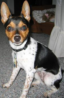

In [19]:
# Test Visualizing a random Image
img = data_preprocessing(img_filenames_th[1500][:-6]+'.jpg',0)
img = transform1(img)
img

## *SETTING THE DEVICE*

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## *WORKING ON THE MODEL*

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
def conv3x3(in_channel, out_channel):
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size = 3, stride = 1,
                     padding = 1, dilation = 1,
                     bias = False)

In [23]:
def conv1x1(in_channel, out_channel):
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size = 1, stride = 1,
                     padding = 0, dilation = 1,
                     bias = False)

In [24]:
def init_weight(m):
    """
    Initialize the weights of the given module.

    Args:
        m (torch.nn.Module): The module for weight initialization.
    """

    # Get the class name of the module
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        # If the module is a convolutional layer
        # Initialize the weight using orthogonal initialization with gain = 1
        nn.init.orthogonal_(m.weight, gain=1)
        
        # If the module has bias, set it to zero
        if m.bias is not None:
            m.bias.data.zero_()

    elif classname.find('Batch') != -1:
        # If the module is a batch normalization layer
        # Initialize the weight using normal distribution with mean=1 and std=0.02
        m.weight.data.normal_(1, 0.02)
        
        # Set the bias to zero
        m.bias.data.zero_()

    elif classname.find('Linear') != -1:
        # If the module is a linear layer
        # Initialize the weight using orthogonal initialization with gain = 1
        nn.init.orthogonal_(m.weight, gain=1)
        
        # If the module has bias, set it to zero
        if m.bias is not None:
            m.bias.data.zero_()

    elif classname.find('Embedding') != -1:
        # If the module is an embedding layer
        # Initialize the weight using orthogonal initialization with gain = 1
        nn.init.orthogonal_(m.weight, gain=1)


In [25]:
class Attention(nn.Module):
    """
    Attention module to capture spatial dependencies in an input tensor.

    Args:
        channels (int): The number of input channels.

    Attributes:
        channels (int): The number of input channels.
        theta (nn.Module): The convolutional layer for the theta pathway.
        phi (nn.Module): The convolutional layer for the phi pathway.
        g (nn.Module): The convolutional layer for the g pathway.
        o (nn.Module): The convolutional layer for the output pathway.
        gamma (nn.Parameter): The learnable parameter for scaling the attention output.
    """

    def __init__(self, channels):
        super().__init__()
        self.channels = channels

        # Initialize the convolutional layers
        self.theta  = nn.utils.spectral_norm(conv1x1(channels, channels//8)).apply(init_weight)
        self.phi    = nn.utils.spectral_norm(conv1x1(channels, channels//8)).apply(init_weight)
        self.g      = nn.utils.spectral_norm(conv1x1(channels, channels//2)).apply(init_weight)
        self.o      = nn.utils.spectral_norm(conv1x1(channels//2, channels)).apply(init_weight)

        # Initialize the gamma parameter
        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, inputs):
        """
        Forward pass of the attention module.

        Args:
            inputs (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying attention.
        """

        batch, c, h, w = inputs.size()

        # Apply the convolutional layers to obtain the intermediate feature maps
        theta  = self.theta(inputs)  # Shape: (*, c/8, h, w)
        phi    = F.max_pool2d(self.phi(inputs), [2, 2])  # Shape: (*, c/8, h/2, w/2)
        g      = F.max_pool2d(self.g(inputs), [2, 2])  # Shape: (*, c/2, h/2, w/2)

        # Reshape the feature maps for further computations
        theta  = theta.view(batch, self.channels//8, -1)  # Shape: (*, c/8, h*w)
        phi    = phi.view(batch, self.channels//8, -1)  # Shape: (*, c/8, h*w/4)
        g      = g.view(batch, self.channels//2, -1)  # Shape: (*, c/2, h*w/4)

        # Compute the attention map using softmax and matrix multiplication
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), -1)  # Shape: (*, h*w, h*w/4)

        # Compute the output by multiplying the attention map with the g pathway and reshape
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(batch, self.channels//2, h, w))  # Shape: (*, c, h, w)

        # Scale the attention output with the gamma parameter and add it to the input tensor
        return self.gamma * o + inputs

In [26]:
class ConditionalNorm(nn.Module):
    """
    Conditional normalization module to conditionally adjust the normalization of an input tensor.

    Args:
        in_channel (int): The number of input channels.
        n_condition (int): The dimensionality of the condition.

    Attributes:
        bn (nn.BatchNorm2d): The batch normalization layer.
        embed (nn.Linear): The linear layer for embedding the condition.
    """

    def __init__(self, in_channel, n_condition):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channel, affine=False)  # No learning parameters
        self.embed = nn.Linear(n_condition, in_channel * 2)

        # Initialize the weights of the embedding layer
        nn.init.orthogonal_(self.embed.weight.data[:, :in_channel], gain=1)
        self.embed.weight.data[:, in_channel:].zero_()

    def forward(self, inputs, label):
        """
        Forward pass of the conditional normalization module.

        Args:
            inputs (torch.Tensor): The input tensor.
            label (torch.Tensor): The condition tensor.

        Returns:
            torch.Tensor: The normalized and conditioned output tensor.
        """
        out = self.bn(inputs)
        embed = self.embed(label.float())
        gamma, beta = embed.chunk(2, dim=1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        out = gamma * out + beta
        return out

In [27]:
class ResBlock_G(nn.Module):
    """
    Residual block module for the generator in BigGAN, using leaky ReLU activation.

    Args:
        in_channel (int): The number of input channels.
        out_channel (int): The number of output channels.
        condition_dim (int): The dimensionality of the condition.
        upsample (bool, optional): Whether to perform upsampling. Default is True.

    Attributes:
        cbn1 (ConditionalNorm): The first conditional normalization layer.
        upsample (nn.Sequential): The upsampling layer.
        conv3x3_1 (nn.Module): The first spectral normalized convolutional layer.
        cbn2 (ConditionalNorm): The second conditional normalization layer.
        conv3x3_2 (nn.Module): The second spectral normalized convolutional layer.
        conv1x1 (nn.Module): The spectral normalized 1x1 convolutional layer.
    """

    def __init__(self, in_channel, out_channel, condition_dim, upsample=True):
        super().__init__()

        # Conditional normalization layers
        self.cbn1 = ConditionalNorm(in_channel, condition_dim)
        self.cbn2 = ConditionalNorm(out_channel, condition_dim)

        # Upsampling layer
        self.upsample = nn.Sequential()
        if upsample:
            self.upsample.add_module('upsample', nn.Upsample(scale_factor=2, mode='nearest'))

        # Convolutional layers
        self.conv3x3_1 = nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight)
        self.conv3x3_2 = nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight)
        self.conv1x1 = nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight)

    def forward(self, inputs, condition):
        """
        Forward pass of the residual block module.

        Args:
            inputs (torch.Tensor): The input tensor.
            condition (torch.Tensor): The condition tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = F.leaky_relu(self.cbn1(inputs, condition))
        x = self.upsample(x)
        x = self.conv3x3_1(x)
        x = self.conv3x3_2(F.leaky_relu(self.cbn2(x, condition)))
        x += self.conv1x1(self.upsample(inputs))  # Shortcut connection
        return x

In [28]:
class Generator(nn.Module):
    """
    Generator module in BigGAN.

    Args:
        n_feat (int): The number of base feature maps.
        codes_dim (int, optional): The dimensionality of the codes. Default is 24.
        n_classes (int, optional): The number of classes. Default is n_classes.

    Attributes:
        fc (nn.Sequential): The fully connected layer.
        res1 (ResBlock_G): The first residual block.
        res2 (ResBlock_G): The second residual block.
        res3 (ResBlock_G): The third residual block.
        res4 (ResBlock_G): The fourth residual block.
        conv (nn.Sequential): The final convolutional layer.
    """

    def __init__(self, n_feat, codes_dim=24, n_classes=n_classes):
        super().__init__()

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(codes_dim, 16*n_feat*4*4)).apply(init_weight)
        )

        # Residual blocks
        self.res1 = ResBlock_G(16*n_feat, 16*n_feat, codes_dim+n_classes, upsample=True)
        self.res2 = ResBlock_G(16*n_feat, 8*n_feat, codes_dim+n_classes, upsample=True)
        #self.attn2 = Attention(8*n_feat)
        self.res3 = ResBlock_G(8*n_feat, 4*n_feat, codes_dim+n_classes, upsample=True)
        self.attn = Attention(4*n_feat)
        self.res4 = ResBlock_G(4*n_feat, 2*n_feat, codes_dim+n_classes, upsample=True)

        # Final convolutional layer
        self.conv = nn.Sequential(
            #nn.BatchNorm2d(2*n_feat).apply(init_weight),
            nn.LeakyReLU(),
            nn.utils.spectral_norm(conv3x3(2*n_feat, 3)).apply(init_weight),
        )

    def forward(self, z, label_ohe, codes_dim=24):
        """
        Forward pass of the generator module.

        Args:
            z (torch.Tensor): The input tensor.
            label_ohe (torch.Tensor): The one-hot encoded label tensor.
            codes_dim (int, optional): The dimensionality of the codes. Default is 24.

        Returns:
            torch.Tensor: The generated output tensor.
        """
        batch = z.size(0)
        z = z.squeeze()  # Squeeze the tensor to remove unnecessary dimensions
        label_ohe = label_ohe.squeeze()  # Squeeze the tensor to remove unnecessary dimensions
        codes = torch.split(z, codes_dim, dim=1)  # Split the input tensor into codes

        x = self.fc(codes[0])  # Shape: (*, 16ch*4*4)
        x = x.view(batch, -1, 4, 4)  # Reshape the tensor to (*, 16ch, 4, 4)

        condition = torch.cat([codes[1], label_ohe], dim=1)  # Concatenate the condition with the label tensor
        x = self.res1(x, condition)  # Apply the first residual block to the tensor -> Shape: (*, 16ch, 8, 8)

        condition = torch.cat([codes[2], label_ohe], dim=1)  # Concatenate the condition with the label tensor
        x = self.res2(x, condition)  # Apply the second residual block to the tensor -> Shape: (*, 8ch, 16, 16)
        #x = self.attn2(x)  # Attention module (not changing the shape)

        condition = torch.cat([codes[3], label_ohe], dim=1)  # Concatenate the condition with the label tensor
        x = self.res3(x, condition)  # Apply the third residual block to the tensor -> Shape: (*, 4ch, 32, 32)
        x = self.attn(x)  # Attention module (not changing the shape)

        condition = torch.cat([codes[4], label_ohe], dim=1)  # Concatenate the condition with the label tensor
        x = self.res4(x, condition)  # Apply the fourth residual block to the tensor -> Shape: (*, 2ch, 64, 64)

        x = self.conv(x)  # Apply the final convolutional layer to the tensor -> Shape: (*, 3, 64, 64)
        x = torch.tanh(x)  # Apply the tanh activation function to the tensor
        return x

In [29]:
class ResBlock_D(nn.Module):
    """
    Residual block module for the discriminator in BigGAN.

    Args:
        in_channel (int): The number of input channels.
        out_channel (int): The number of output channels.
        downsample (bool, optional): Whether to perform downsampling. Default is True.

    Attributes:
        layer (nn.Sequential): The sequential layers in the block.
        shortcut (nn.Sequential): The shortcut connection.
    """

    def __init__(self, in_channel, out_channel, downsample=True):
        super().__init__()

        # Sequential layers in the block
        self.layer = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight),
        )

        # Shortcut connection
        self.shortcut = nn.Sequential(
            nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight),
        )

        if downsample:
            # Downsample layers
            self.layer.add_module('avgpool', nn.AvgPool2d(kernel_size=2, stride=2))
            self.shortcut.add_module('avgpool', nn.AvgPool2d(kernel_size=2, stride=2))

    def forward(self, inputs):
        """
        Forward pass of the residual block module.

        Args:
            inputs (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = self.layer(inputs)
        x += self.shortcut(inputs)
        return x

In [30]:
class Discriminator(nn.Module):
    """
    Discriminator module in BigGAN.

    Args:
        n_feat (int): The number of base feature maps.
        n_classes (int, optional): The number of classes. Default is n_classes.

    Attributes:
        res1 (ResBlock_D): The first residual block.
        attn (Attention): The attention module.
        res2 (ResBlock_D): The second residual block.
        res3 (ResBlock_D): The third residual block.
        res4 (ResBlock_D): The fourth residual block.
        res5 (ResBlock_D): The fifth residual block.
        fc (nn.Linear): The linear layer for classification.
        embedding (nn.Embedding): The embedding layer for class conditioning.
    """

    def __init__(self, n_feat, n_classes=n_classes):
        super().__init__()

        # Residual blocks
        self.res1 = ResBlock_D(3, n_feat, downsample=True)
        self.attn = Attention(n_feat)
        self.res2 = ResBlock_D(n_feat, 2*n_feat, downsample=True)
        #self.attn2 = Attention(2*n_feat)
        self.res3 = ResBlock_D(2*n_feat, 4*n_feat, downsample=True)
        self.res4 = ResBlock_D(4*n_feat, 8*n_feat, downsample=True)
        self.res5 = ResBlock_D(8*n_feat, 16*n_feat, downsample=False)

        # Linear layer for classification
        self.fc = nn.utils.spectral_norm(nn.Linear(16*n_feat, 1)).apply(init_weight)

        # Embedding layer for class conditioning
        self.embedding = nn.Embedding(num_embeddings=n_classes, embedding_dim=16*n_feat).apply(init_weight)

    def forward(self, inputs, label):
        """
        Forward pass of the discriminator module.

        Args:
            inputs (torch.Tensor): The input tensor.
            label (torch.Tensor): The label tensor.

        Returns:
            torch.Tensor: The discriminator outputs.
        """
        batch = inputs.size(0)  # (*, 3, 64, 64)
        h = self.res1(inputs)  # Apply the first residual block to the inputs -> (*, ch, 32, 32)
        h = self.attn(h)  # Attention module (not changing the shape)
        h = self.res2(h)  # Apply the second residual block to the inputs -> (*, 2ch, 16, 16)
        #h = self.attn2(h)  # Attention module (not changing the shape)
        h = self.res3(h)  # Apply the third residual block to the inputs -> (*, 4ch, 8, 8)
        h = self.res4(h)  # Apply the fourth residual block to the inputs -> (*, 8ch, 4, 4)
        h = self.res5(h)  # Apply the fifth residual block to the inputs -> (*, 16ch, 4, 4)
        h = torch.sum((F.leaky_relu(h, 0.2)).view(batch, -1, 4*4), dim=2)  # GlobalSumPool -> (*, 16ch)
        outputs = self.fc(h)  # Linear classification layer -> (*, 1)

        if label is not None:
            embed = self.embedding(label)  # Embedding layer for class conditioning -> (*, 16ch)
            outputs += torch.sum(embed * h, dim=1, keepdim=True)  # Multiply embeddings with hidden features and sum -> (*, 1)

        outputs = torch.sigmoid(outputs)  # Apply sigmoid activation function to the outputs
        return outputs

In [31]:
# # BigGan
# gen_count_params = count_parameters(model=Generator(n_feat=27, codes_dim=24, n_classes=n_classes))
# disc_count_params = count_parameters(model=Discriminator(n_feat=33, n_classes=n_classes))

# print(f'Total Trainable Parameters in the BigGan Generator = {gen_count_params}')
# print(f'Total Trainable Parameters in the BigGan Discriminator = {disc_count_params}')

## *TRAINING THE MODEL*

In [32]:
def generate_img(netG, fixed_noise, fixed_aux_labels=None):
    """
    Generate an image using the generator network.

    Args:
        netG (nn.Module): The generator network.
        fixed_noise (torch.Tensor): The fixed noise tensor for generating the image.
        fixed_aux_labels (torch.Tensor, optional): The fixed auxiliary labels for conditional generation. Default is None.

    Returns:
        numpy.ndarray: The generated image as a numpy array.
    """
    if fixed_aux_labels is not None:
        gen_image = netG(fixed_noise, fixed_aux_labels).to('cpu').clone().detach().squeeze(0)
    else:
        gen_image = netG(fixed_noise).to('cpu').clone().detach().squeeze(0)

    # Denormalize the generated image
    gen_image = gen_image * 0.5 + 0.5

    # Convert the tensor to a numpy array and transpose the dimensions
    gen_image_numpy = gen_image.numpy().transpose(0, 2, 3, 1)

    return gen_image_numpy

In [33]:
def show_generate_imgs(netG, fixed_noise, fixed_aux_labels=None):
    """
    Display generated images using the generator network.

    Args:
        netG (nn.Module): The generator network.
        fixed_noise (torch.Tensor): The fixed noise tensor for generating the images.
        fixed_aux_labels (torch.Tensor, optional): The fixed auxiliary labels for conditional generation. Default is None.
    """
    gen_images_numpy = generate_img(netG, fixed_noise, fixed_aux_labels)

    # Create a figure to display the generated images
    fig = plt.figure(figsize=(25, 16))

    # Display 10 images from each class
    for i, img in enumerate(gen_images_numpy):
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        plt.imshow(img)

    plt.show()
    plt.close()

In [34]:
#https://www.kaggle.com/osciiart/resnet34-mel-ver3-log-multi-hardaug?scriptVersionId=13887036
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [35]:
def run(lr_G=3e-4, lr_D=3e-4, beta1=0.0, beta2=0.999, nz=120, epochs=2, n_ite_D=1,
        ema_decay_rate=0.999, show_epoch_list=None, output_freq=10):
    """
    Train the BigGAN model.

    Args:
        lr_G (float): Learning rate for the generator.
        lr_D (float): Learning rate for the discriminator.
        beta1 (float): Beta1 parameter for the Adam optimizer.
        beta2 (float): Beta2 parameter for the Adam optimizer.
        nz (int): Size of the generator input noise.
        epochs (int): Number of training epochs.
        n_ite_D (int): Number of iterations to update the discriminator per generator iteration.
        ema_decay_rate (float): Decay rate for the exponential moving average of the generator.
        show_epoch_list (list): List of epochs to display generated images.
        output_freq (int): Frequency of outputting loss information during training.

    Returns:
        dict: Dictionary containing the trained models and other training results.
    """
    # print('Function started!!')

    # Initialize the generator and discriminator models
    netG = Generator(n_feat=36, codes_dim=24, n_classes=n_classes).to(device)
    # print('netg executed!')
    
    netD = Discriminator(n_feat=42, n_classes=n_classes).to(device)
    # print('netd executed!')
    
    if EMA:
        #EMA of G for sampling
        netG_EMA = Generator(n_feat=42, codes_dim=24, n_classes=n_classes).to(device)
        netG_EMA.load_state_dict(netG.state_dict())
        for p in netG_EMA.parameters():
            p.requires_grad = False

    # Print the total number of trainable parameters for each model
    print(f'Total Trainable Generator Parameters = {count_parameters(netG)}')
    print(f'Total Trainable Discriminator Parameters = {count_parameters(netD)}')
    print()

    # Set the real and fake labels
    real_label = 0.9
    fake_label = 0

    # print('real and fake labels set!!')

    # Lists to store the generator and discriminator losses
    D_loss_list = []
    G_loss_list = []

    # print('Lists to store gen and disc loss initialized!!')

    # Define the discriminator loss criterion
    dis_criterion = nn.BCELoss().to(device)

    # print('loss criteria defined!!')

    # Initialize the optimizers for generator and discriminator
    optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
    # print('disc optimizer initialized!!!')
    
    optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))  
    # print('gen optimizer initialized!!!')

    # Initialize the fixed noise and auxiliary labels for visualization
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)
    fixed_aux_labels = np.random.randint(0, n_classes, 32)
    fixed_aux_labels_ohe = np.eye(n_classes)[fixed_aux_labels]
    fixed_aux_labels_ohe = torch.from_numpy(fixed_aux_labels_ohe[:, :, np.newaxis, np.newaxis])
    fixed_aux_labels_ohe = fixed_aux_labels_ohe.float().to(device, non_blocking=True)

    # print('Fixed and auxilliary noise labels initialized!!')

    # Set the models to training mode
    netG.train()
    # print('generator set to training mode')
    
    netD.train()
    # print('discriminator set to training mode')

    # Training loop
    for epoch in range(1, epochs + 1):
        # print('Training Loop started!!')
      
        # Print elapsed time if it exceeds the time limit
        if elapsed_time(start_time) > TIME_LIMIT:
            print(f'elapsed_time go beyond {TIME_LIMIT} sec')
            break

        # Initialize running losses for discriminator and generator
        D_running_loss = 0
        G_running_loss = 0

        # print('running losses variables defined!!')

        for ii, data in enumerate(tqdm(train_loader)):
            # print('entered loop "enumerate(trainloader)"')
            
            # Update the discriminator multiple times
            for _ in range(n_ite_D):
                # Set the labels for real and fake images
                if LABEL_NOISE:
                    real_label = 0.9
                    fake_label = 0
                    if np.random.random() < LABEL_NOISE_PROB:
                        real_label = 0
                        fake_label = 0.9

                # Train with real images
            
                # print('started training with real images!!')
            
                netD.zero_grad()
                real_images = data[0].to(device, non_blocking=True)
                batch_size = real_images.size(0)
                dis_labels = torch.full((batch_size, 1), real_label, device=device)
                aux_labels = data[1].long().to(device, non_blocking=True)
                dis_output = netD(real_images, aux_labels)
                errD_real = dis_criterion(dis_output, dis_labels)
                errD_real.backward(retain_graph=True)
                
                # print('Done training with real images!!')

                # Train with fake images
                
                # print('started training with fake images!!')
                
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                aux_labels = np.random.randint(0, n_classes, batch_size)
                aux_labels_ohe = np.eye(n_classes)[aux_labels]
                aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:, :, np.newaxis, np.newaxis])
                aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
                aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
                
                # print('Done training with fake images!!')

                fake = netG(noise, aux_labels_ohe)
                dis_labels.fill_(fake_label)
                dis_output = netD(fake.detach(), aux_labels)
                errD_fake = dis_criterion(dis_output, dis_labels)
                errD_fake.backward(retain_graph=True)

                # Accumulate the discriminator loss
                D_running_loss += (errD_real.item() + errD_fake.item()) / len(train_loader)
                
                # print('Discr loss accumulated!!')

                optimizerD.step()

            # Update the generator
            
            # print('updating the gen')
            
            netG.zero_grad()
            dis_labels.fill_(real_label)  # fake labels are real for generator cost
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            aux_labels     = np.random.randint(0,n_classes, batch_size)
            aux_labels_ohe = np.eye(n_classes)[aux_labels]
            aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
            aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
            aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
            fake  = netG(noise, aux_labels_ohe)
            
            dis_output = netD(fake, aux_labels)
            errG   = dis_criterion(dis_output, dis_labels)
            errG.backward(retain_graph=True)
            
            # print('updated the gen')


            # Accumulate the generator loss
            G_running_loss += errG.item()/len(train_loader)
            
            optimizerG.step()

        # Update the exponential moving average of the generator if enabled
        # print('updating the ema')
        
        if EMA:
            # print('If check passed!, entered ema updating if check loop')
            param_itr = cycle(netG.parameters())
            for i,p_EMA in enumerate(netG_EMA.parameters()):
                p = next(param_itr)
                p_EMA.data = (1-ema_decay_rate)*p_EMA.data + ema_decay_rate*p.data
                p_EMA.requires_grad = False

        # Log the discriminator and generator losses
        # print('logging disc and gen losses')
        
        D_loss_list.append(D_running_loss)
        G_loss_list.append(G_running_loss)
        
        # print('disc and gen losses logged')

        # Output loss information and generated images at specified intervals
        if epoch % output_freq == 0:
            print('[{:d}/{:d}] D_loss = {:.3f}, G_loss = {:.3f}, elapsed_time = {:.1f} min'.format(epoch,epochs,D_running_loss,G_running_loss,elapsed_time(start_time)/60))
            
        if epoch in show_epoch_list:
            print('epoch = {}'.format(epoch))
            if not EMA:
                show_generate_imgs(netG,fixed_noise,fixed_aux_labels_ohe)
            elif EMA:
                show_generate_imgs(netG_EMA,fixed_noise,fixed_aux_labels_ohe)

        # Save the models at specified intervals
        if epoch % 50 == 0:
            if not EMA:
                torch.save(netG.state_dict(), f'generator_epoch{epoch}.pth')
            elif EMA:
                torch.save(netG_EMA.state_dict(), f'generator_epoch{epoch}.pth')

    # Save the final models
    if not EMA:
        torch.save(netG.state_dict(), 'generator.pth')
    elif EMA:
        torch.save(netG_EMA.state_dict(), 'generator.pth')
    torch.save(netD.state_dict(), 'discriminator.pth')

    # Prepare the results dictionary
    res = {'netG':netG,
           'netD':netD,
           'nz':nz,
           'fixed_noise':fixed_noise,
           'fixed_aux_labels_ohe':fixed_aux_labels_ohe,
           'D_loss_list':D_loss_list,
           'G_loss_list':G_loss_list,
          }
    if EMA:
        res['netG_EMA'] = netG_EMA
        
    return res

Total Trainable Generator Parameters = 10491625
Total Trainable Discriminator Parameters = 8497274



100%|██████████| 690/690 [02:36<00:00,  4.41it/s]


[10/500] D_loss = 1.116, G_loss = 1.146, elapsed_time = 27.1 min
epoch = 10


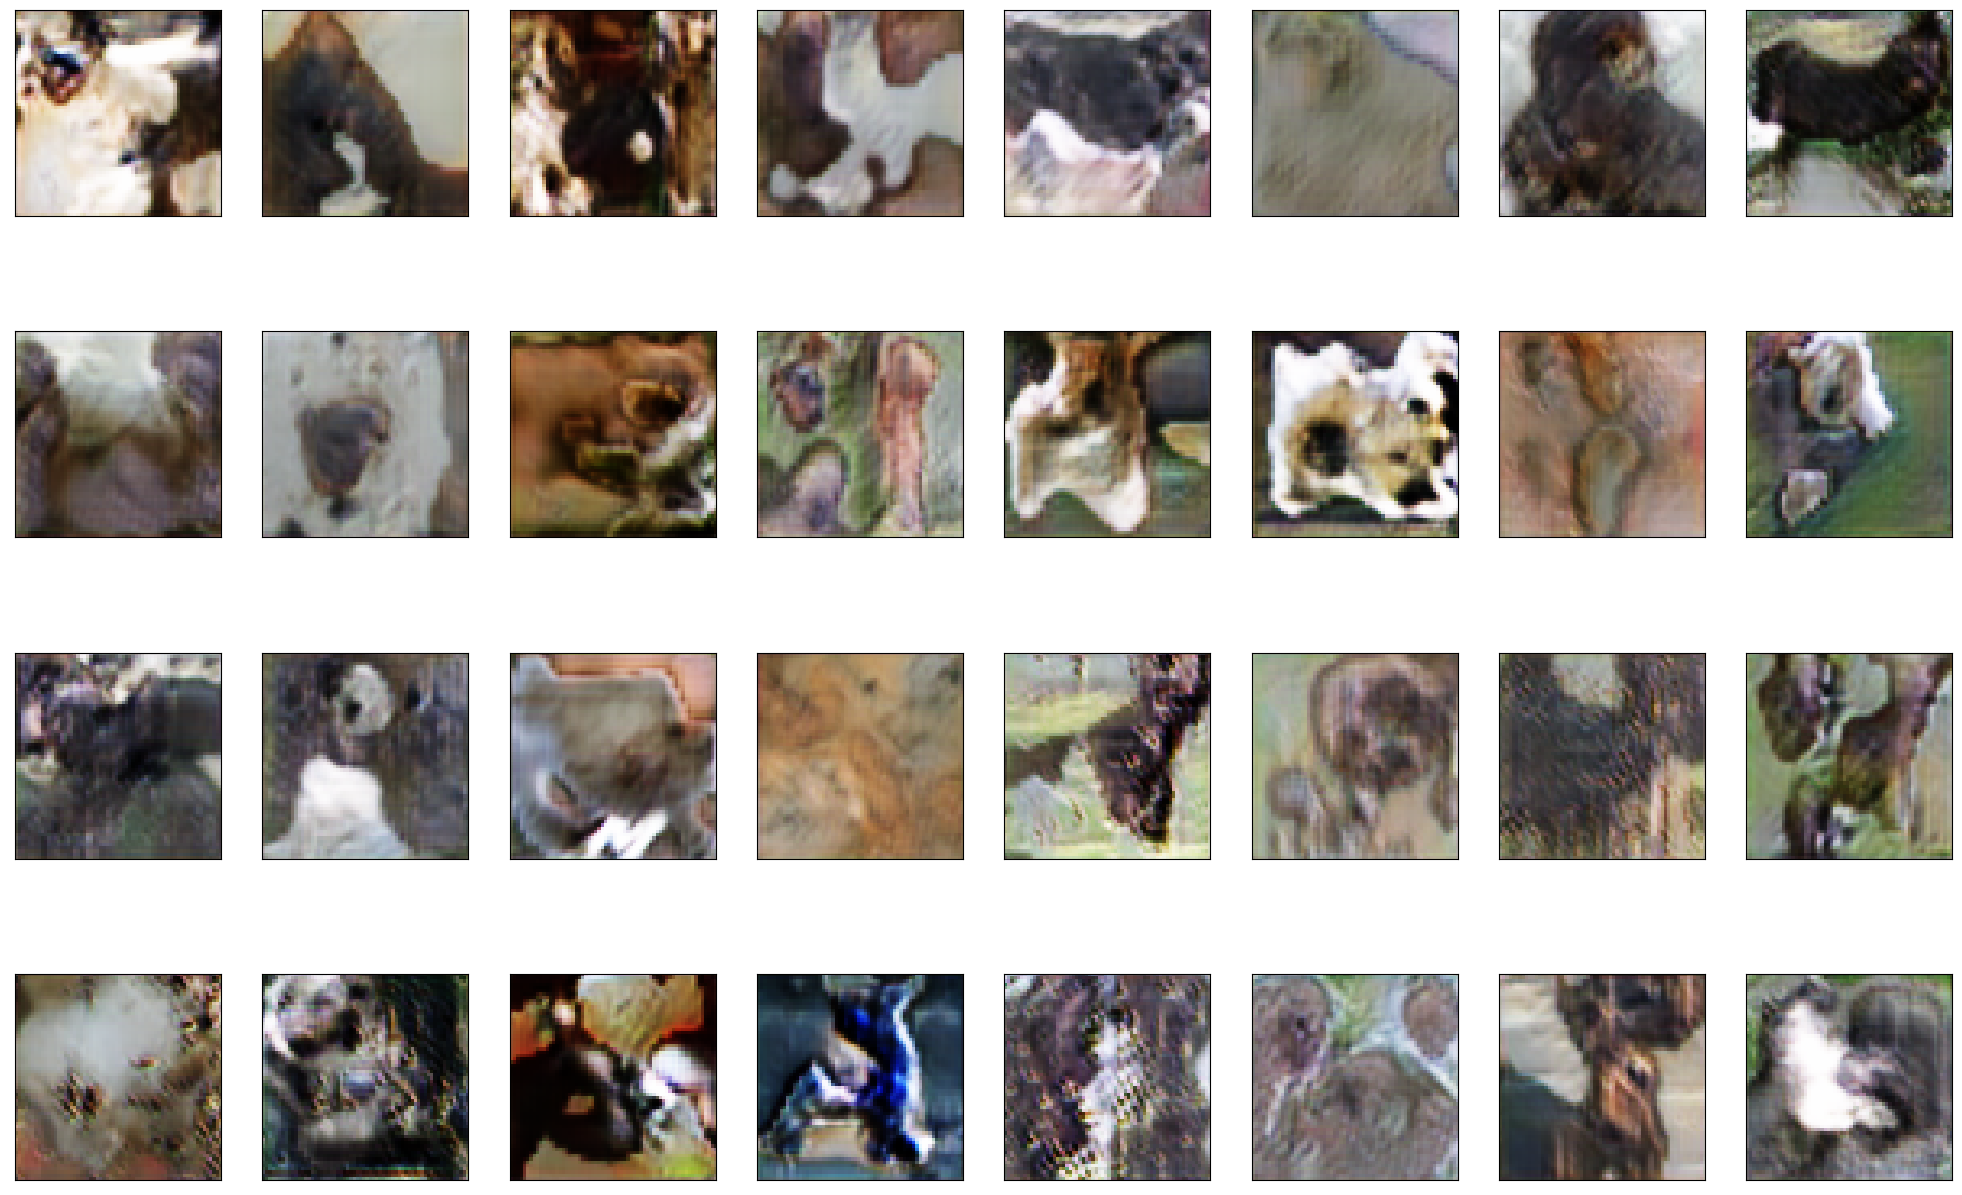

100%|██████████| 690/690 [02:34<00:00,  4.47it/s]


[20/500] D_loss = 0.967, G_loss = 1.418, elapsed_time = 53.9 min
epoch = 20


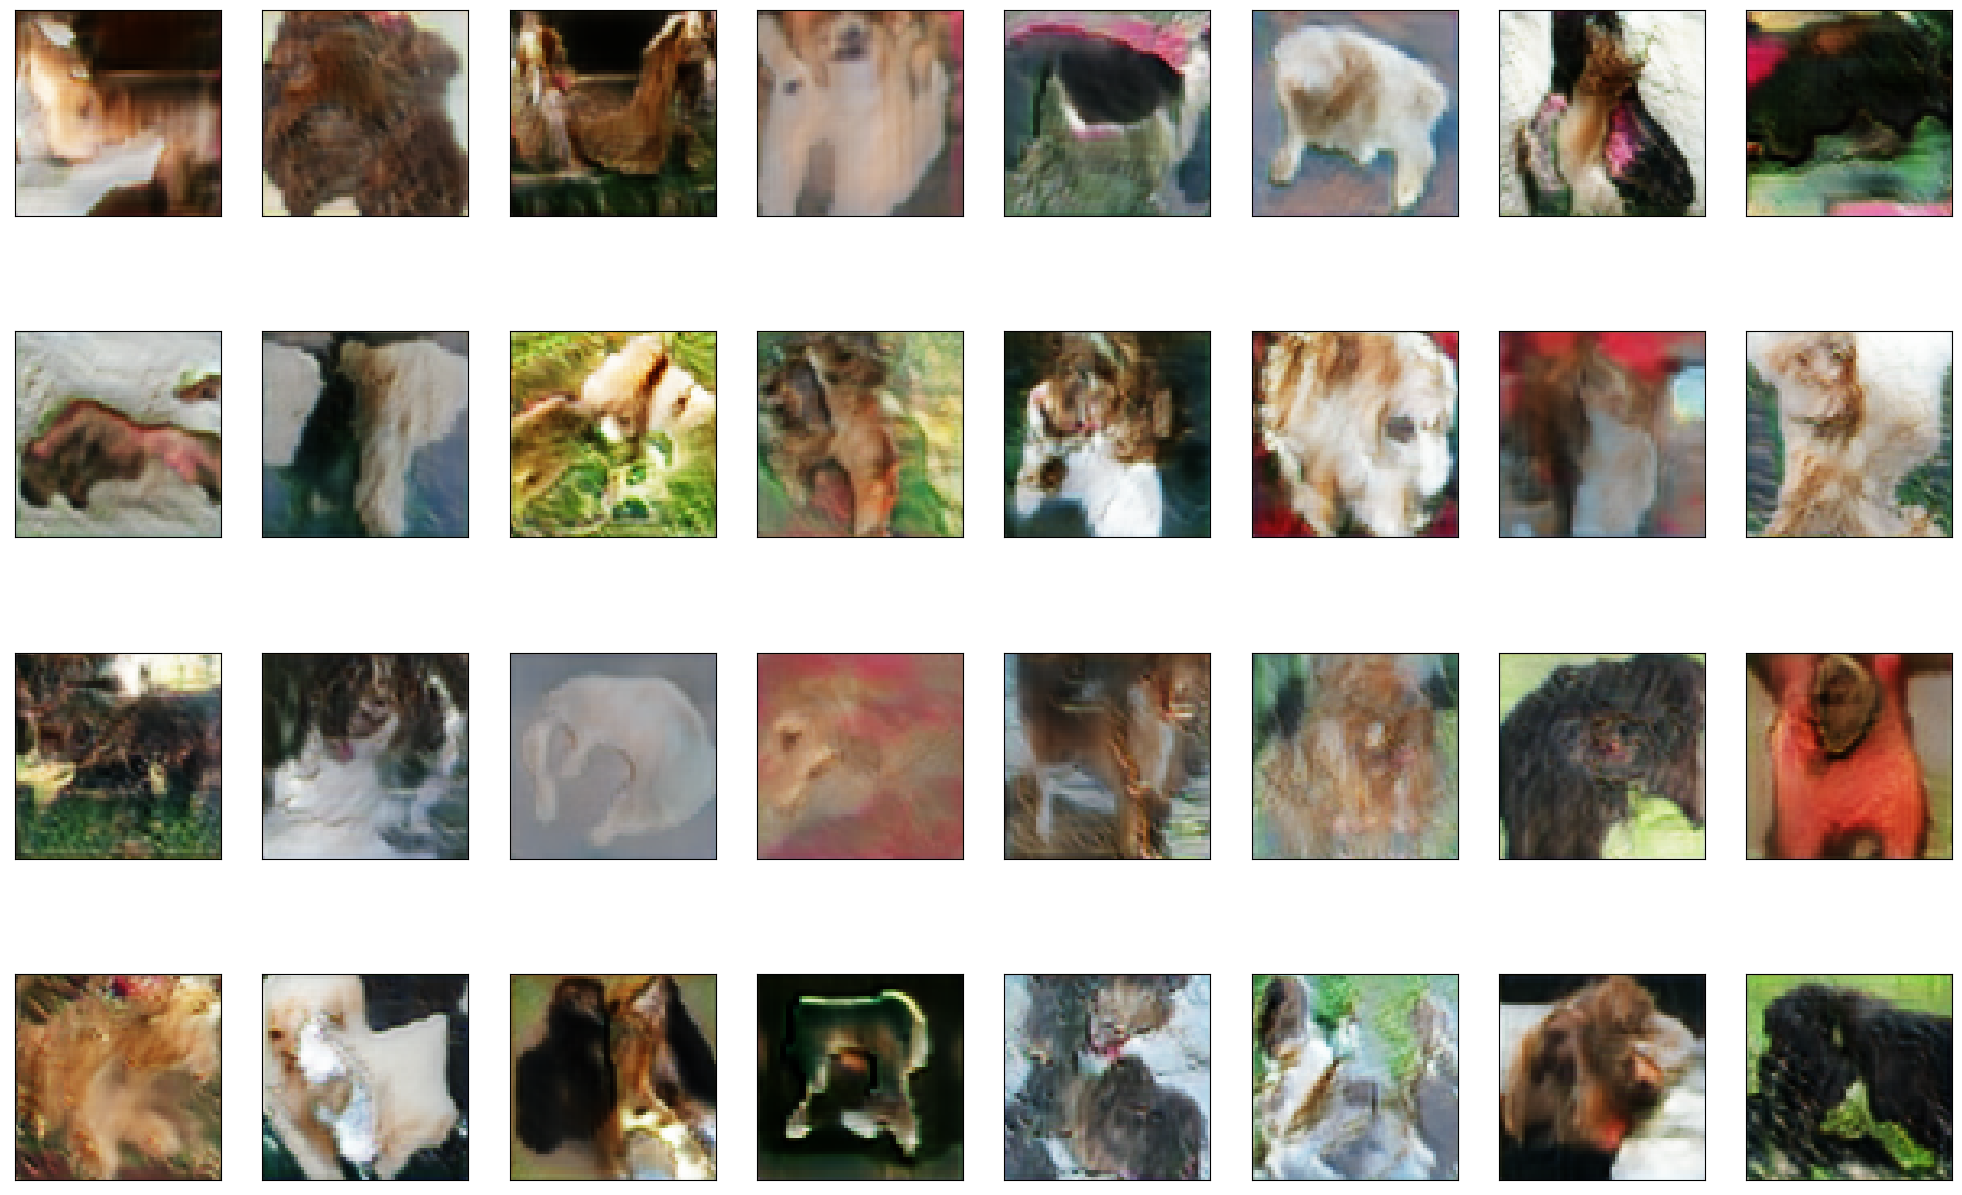

 77%|███████▋  | 530/690 [01:59<00:35,  4.50it/s]

In [36]:
%%time
#show_epoch_list = np.arange(0,100,1)
show_epoch_list = np.arange(0,500+10,10)

res = run(lr_G=3e-4,lr_D=3e-4, beta1=0.0, beta2=0.999, nz=120, epochs=500, 
          n_ite_D=1, ema_decay_rate=None, show_epoch_list=show_epoch_list, output_freq=10)
# res = run(lr_G=3e-4,lr_D=3e-4, beta1=0.5, beta2=0.999, nz=120, epochs=500, 
#           n_ite_D=1, ema_decay_rate=None, show_epoch_list=show_epoch_list, output_freq=10)